In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# the following model takes in a CSV file with the optical flow data
# the model is a vanilla CNN + a transformer encoder
# the output is a (batch_size, num_classes) matrix where the row indicates the trial, and the column indicates the class
# each entry is the probability that the trial corresponds to that particular class
# the classes are the number of layers: 0,1,2
import torch
print("Using torch", torch.__version__)

Using torch 2.3.0+cu121


In [ ]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
import cv2

In [ ]:
# filter the data to remove the sections in the video where the force threshold hasn't yet been met
# commented since all 300 trials of data have already been filtered

# def filter_csv_data(input_file, output_file, threshold=-1.25):
#     # Load the CSV file
#     data = pd.read_csv(input_file)

#     # Find the first occurrence where force_x exceeds the threshold
#     index_threshold = data[data['force_x'] > threshold].index[0]

#     # Keep all rows after this index
#     filtered_data = data.iloc[index_threshold:]

#     # Save the filtered data to a new CSV file
#     filtered_data.to_csv(output_file, index=False)

#     return index_threshold

# def process_video(input_video, output_video, start_frame):
#     # Open the input video
#     cap = cv2.VideoCapture(input_video)

#     # Get video properties
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

#     frame_count = 0
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Write frames starting from the start_frame
#         if frame_count >= start_frame:
#             out.write(frame)

#         frame_count += 1

#     print(f'Frames of input video: {frame_count}')
#     print(f'Frames of output video: {frame_count - start_frame}')

#     # Release everything if job is finished
#     cap.release()
#     out.release()

# def process_files(video_dir, video_output_dir, wrench_dir, wrench_output_dir, wrench_prefix='wrench_data_', video_prefix='output_', output_video_prefix='filtered_video_', threshold=-1.25):
#     # Ensure output directories exist
#     os.makedirs(video_output_dir, exist_ok=True)
#     os.makedirs(wrench_output_dir, exist_ok=True)

#     trial_num = 0
#     while True:
#         input_csv = os.path.join(wrench_dir, f'{wrench_prefix}{trial_num}.csv')
#         # print(input_csv)
#         input_video = os.path.join(video_dir, f'{video_prefix}{trial_num}.avi')
#         if not os.path.exists(input_csv) or not os.path.exists(input_video):
#             print(f'Files not found: {input_csv}, {input_video}')
#             break
#         output_video = os.path.join(video_output_dir, f'{output_video_prefix}{trial_num}.avi')
#         output_csv = os.path.join(wrench_output_dir, f'filtered_{wrench_prefix}{trial_num}.csv')
#         start_frame = filter_csv_data(input_csv, output_csv, threshold)
#         print(f'Processed {input_csv} -> {output_csv}')
#         process_video(input_video, output_video, start_frame)
#         print(f'Processed {input_video} -> {output_video}')
#         trial_num += 1

# data_path = '/content/drive/MyDrive/soft_manipulation_videos/tests_5_28'
# layer_str_arr = ['0_layer', '1_layer','2_layer']
# for layer_str in layer_str_arr:
#     wrench_dir = os.path.join(data_path, f'raw_data_5_28/wrench_data/{layer_str}')
#     video_dir = os.path.join(data_path, f'raw_data_5_28/output_videos/{layer_str}')
#     video_output_dir = os.path.join(data_path, f'filtered_test_data_5_28/video_data/{layer_str}')
#     wrench_output_dir = os.path.join(data_path, f'filtered_test_data_5_28/wrench_data/{layer_str}')
#     process_files(video_dir, video_output_dir, wrench_dir, wrench_output_dir)


In [ ]:
!pip install filters

In [ ]:
# TO DO: finish editing this block to determine the optical flow
# determine the optical flow

# (batch_size, channels, height, width)
# batch_size is number of trials
# channels is 2 (x,y) of flow vector. or can extract magnitude and direction
# height and width of image

####################
##  [python 3 /2 problems](https://answers.ros.org/question/345942/modulenotfounderror-no-module-named-netifaces/)
####################

import struct
import sys
import numpy as np
import matplotlib.pyplot as plt
import filters
import math
from matplotlib import gridspec
import argparse
# import os
# import cv2

# Params for data analysis
cap_reps = 7        # number of times to repeat frame capture before performing optical flow
comparison_rate = 10/cap_reps  # frame-rate of optical flow comparison (Hz)

def denseOpticalFlow(file_path, filename="output"):
    # define a video capture object
    cap = cv2.VideoCapture(file_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'postprocess_vids/{filename}_postprocess.mp4', fourcc, 10.0, (1600, 1200))

    # Create random colors
    color = np.random.randint(0, 255, (300, 3))
    ret, frame = cap.read()

    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(frame)
    mask[..., 1] = 255

    # shape of flow vals: (num_channels (2), depth (num_sampled_frames), height, width). 0th channel has magnitudes, 1st channel has angles
    frame_idx = 0

    while True:

        # print("frame index: ", frame_idx)

        ##### to define new feature for each cycle

        # Read new frame
        # Repeat this line n times to only compare every nth frame
        for i in range(cap_reps):
            ret, frame = cap.read()

        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray,
                                            None,
                                            0.5,
                                            2,
                                            8,
                                            2,
                                            5,
                                            1.1,
                                            0)

        # Computes the magnitude and angle of the 2D vectors
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        height = mag.shape[0]
        width = mag.shape[1]
        mag = np.expand_dims(np.expand_dims(mag, axis=0), axis=0)
        ang = np.expand_dims(np.expand_dims(ang, axis=0), axis=0)
        # print("mag.shape: ", mag.shape)
        # print("ang.shape: ", ang.shape)

        if frame_idx == 0: # first frame
            curr_flow_vals = np.zeros((2, 1, height, width))
            all_flow_vals = np.zeros((2, 1, height, width))

        curr_flow_vals[0, 0, :, :] = mag
        curr_flow_vals[1, 0, :, :] = ang

        if frame_idx == 0:
            all_flow_vals = curr_flow_vals
        else:
            all_flow_vals = np.concatenate((all_flow_vals, curr_flow_vals), axis=1)

        frame_idx += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    out.release()
    cap.release()
    cv2.destroyAllWindows()

    # print("shape of all_flow_vals: ", all_flow_vals.shape)

    return all_flow_vals

def main(folder_path):

    flow_data = [] # list where each entry is a matrix of flow values for a single trial

    if not os.path.isdir(folder_path):
        print(f"The path '{folder_path}' is not a directory.")
        return

    num_trials = 0
    # Loop through each file in each folder in the directory
    for entry in os.listdir(folder_path): # for each folder (0_layer, 1_layer, 2_layer)
        subfolder_path = os.path.join(folder_path, entry)
        num_layers = int(entry.split('_')[0])
        print("num_layers: ", num_layers)
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name) # Get the full path of the file
            if os.path.isfile(file_path): # Check if the path is a file (not a directory)
                print(file_name)
                # flow_vals = denseOpticalFlow(file_path, file_name)
                trial_flow_vals = denseOpticalFlow(file_path, file_name) # all flow values for a single trial
                # here can do the sub-sampling to e
                flow_data.append(trial_flow_vals)
                num_trials += 1
                if num_trials >= 1:
                    print("length of list = ", len(flow_data))
                    return flow_data

    print("length of list = ", len(flow_data))
    return flow_data


# data_path = '/content/drive/MyDrive/soft_manipulation_videos/tests_5_28/filtered_test_data_5_28/video_data'
# main(data_path)
# flow_data = main(data_path)

In [ ]:
flows_0 = np.load('/content/drive/MyDrive/soft_manipulation_videos/final_data/0layer_trials_alldata_avgpoolby6_2.npz')["flow_data"]
flows_1 = np.load('/content/drive/MyDrive/soft_manipulation_videos/final_data/1layer_trials_alldata_avgpoolby6_2.npz')["flow_data"]
flows_2 = np.load('/content/drive/MyDrive/soft_manipulation_videos/final_data/2layer_trials_alldata_avgpoolby6_2.npz')["flow_data"]

In [ ]:
mags_0 = flows_0[:,0,:,:,:]
mags_0_train = mags_0[:75].reshape(75*23, 128, 170)[:, np.newaxis, :, :]
mags_0_test = mags_0[75:].reshape(25*23, 128, 170)[:, np.newaxis, :, :]

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# class Encoder(nn.Module):
#     def __init__(self, H, W):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1) # (H/2, W/2, 16)
#         # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # (H/4, W/4, 32)
#         # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # (H/8, W/8, 64)
#         # self.fc1 = nn.Linear((H // 4) * (W // 4) * 64, 100) # Assuming H and W are divisible by 8
#         self.fc1 = nn.Linear(87040, 100) # Assuming H and W are divisible by 8
#         self.fc2 = nn.Linear(100, 30)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         print(x.shape)
#         # x = torch.relu(self.conv2(x))
#         # print(x.shape)
#         # x = torch.relu(self.conv3(x))
#         x = x.view(x.size(0), -1) # Flatten
#         print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, H, W):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(30, 100)
#         # self.fc2 = nn.Linear(100, (H // 4) * (W // 4) * 64)
#         self.fc2 = nn.Linear(100, 87040)
#         # self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1) # (H/4, W/4, 32)
#         # self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) # (H/2, W/2, 16)
#         self.deconv3 = nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1) # (H, W, 2)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = x.view(x.size(0), 64, H // 4, W // 4) # Reshape
#         x = x.view(x.size(0), 64, int(87040/64)) # Reshape
#         # x = F.relu(self.deconv1(x))
#         # x = F.relu(self.deconv2(x))
#         x = F.sigmoid(self.deconv3(x)) # Use sigmoid to output values in [0, 1]
#         return x

# class Autoencoder(nn.Module):
#     def __init__(self, H, W):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder(H, W)
#         self.decoder = Decoder(H, W)

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=(1, 2))  # (N, 16, 64, 85)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=(1, 2))  # (N, 32, 32, 43)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # (N, 64, 16, 22)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # (N, 128, 8, 11)
        self.fc1 = nn.Linear(128 * 8 * 11, 256)  # Latent vector size = 256

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(256, 128 * 8 * 11)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 64, 16, 22)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 32, 32, 43)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=(1, 2), output_padding=1)  # (N, 16, 64, 85)
        self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=(1, 2), output_padding=1)  # (N, 1, 128, 170)

        # self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 64, 16, 22)
        # self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 32, 32, 43)
        # self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 16, 64, 85)
        # self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # (N, 1, 128, 170)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(x.size(0), 128, 8, 11)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        # x = torch.sigmoid(x)  # Use sigmoid for final activation to get pixel values between 0 and 1
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
# trial1 = np.transpose(flows_0[0], (1, 0, 2, 3))
# trial1 = flows_0[0][0][:, np.newaxis, :, :]
input_data = torch.from_numpy(mags_0_train).float()

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(input_data)
    # print(output.shape)
    loss = criterion(output, input_data)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 7.6957
Epoch [2/500], Loss: 7.6840
Epoch [3/500], Loss: 7.6602
Epoch [4/500], Loss: 7.5548
Epoch [5/500], Loss: 7.1548
Epoch [6/500], Loss: 6.0218
Epoch [7/500], Loss: 4.5813
Epoch [8/500], Loss: 7.1857
Epoch [9/500], Loss: 3.9369
Epoch [10/500], Loss: 4.5338
Epoch [11/500], Loss: 5.1385
Epoch [12/500], Loss: 5.3740
Epoch [13/500], Loss: 5.3066
Epoch [14/500], Loss: 4.9569
Epoch [15/500], Loss: 4.3038
Epoch [16/500], Loss: 3.4204
Epoch [17/500], Loss: 2.9538
Epoch [18/500], Loss: 3.8998
Epoch [19/500], Loss: 3.4480
Epoch [20/500], Loss: 2.5218
Epoch [21/500], Loss: 2.5108
Epoch [22/500], Loss: 2.7352
Epoch [23/500], Loss: 2.7593
Epoch [24/500], Loss: 2.5167
Epoch [25/500], Loss: 2.1420
Epoch [26/500], Loss: 1.9848
Epoch [27/500], Loss: 2.2561
Epoch [28/500], Loss: 2.2147
Epoch [29/500], Loss: 1.8410
Epoch [30/500], Loss: 1.7789
Epoch [31/500], Loss: 1.8962
Epoch [32/500], Loss: 1.9172
Epoch [33/500], Loss: 1.7868
Epoch [34/500], Loss: 1.6376
Epoch [35/500], Loss: 1

In [ ]:
# test model
test_data_tensor = torch.from_numpy(mags_0_test)
model.eval()
with torch.no_grad():
    outputs_test = model(test_data_tensor.T.float())
    # print(outputs_test.shape)

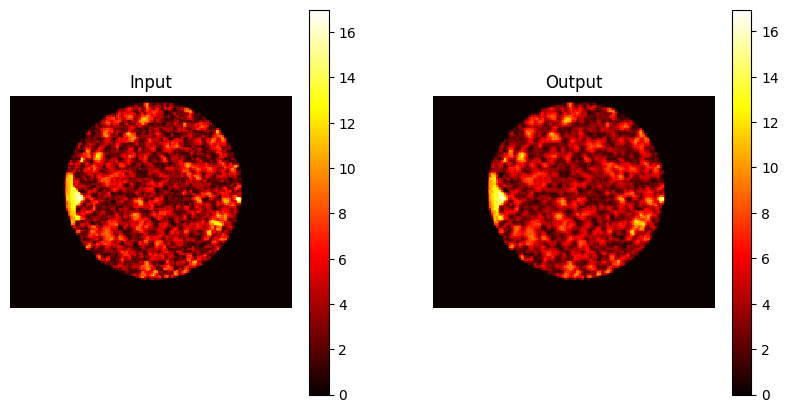

In [ ]:
# fig, ax = plt.subplots()

# frame = input_data[0]
# H = frame.shape[1]
# W = frame.shape[2]
# for i in range(H):
#    for j in range(W):
#       mag = frame[0,i,j]
#       angle = frame[1,i,j]
#       u = mag * np.cos(angle)
#       v = mag * np.sin(angle)
#       ax.quiver(u, v, scale=1, scale_units='xy', angles='xy', pivot='tail')

# Assuming you have your data in a PyTorch tensor of shape [H, W]
frame = 10
input_img = input_data.squeeze(1)[frame]
output_img = output.detach().numpy().squeeze(1)[frame]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# input heatmap
im1 = axs[0].imshow(input_img, cmap='hot', interpolation='nearest')
axs[0].set_title('Input')
axs[0].set_axis_off()  # Hide axes
plt.colorbar(im1, ax=axs[0])  # Add color bar

# output heatmap
im2 = axs[1].imshow(output_img, cmap='hot', interpolation='nearest')
axs[1].set_title('Output')
axs[1].set_axis_off()  # Hide axes
plt.colorbar(im2, ax=axs[1])  # Add color bar

plt.show()

In [ ]:
# postprocessing of force data
def sample_forces(file_path, num_samples=18):
    data_frame = pd.read_csv(file_path)
    force_columns = ['force_x', 'force_y', 'force_z']
    # sampled_data = {col: [] for col in force_columns}

    # Sample evenly spaced values from each force column
    for col in force_columns:
        # Get the total number of rows
        num_rows = len(data_frame)
        # Generate indices for evenly spaced sampling
        indices = np.linspace(0, num_rows - 1, num_samples, dtype=int)
        # Sample values
        Fx = torch.tensor(data_frame.iloc[:,0].values)
        Fy = torch.tensor(data_frame.iloc[:,1].values)
        Fz = torch.tensor(data_frame.iloc[:,2].values)

        sampled_Fx = Fx[indices]
        sampled_Fy = Fy[indices]
        sampled_Fz = Fz[indices]

    return sampled_Fx, sampled_Fy, sampled_Fz

    #     sampled_data[col] = data_frame[col].iloc[indices].values

    # return sampled_data


# def main(args):
    # parser = argparse.ArgumentParser(description="Read a folder path and name from the command line.")
    # parser.add_argument("folder_path", type=str, help="Path folder of to wrench data from DT.")
folder_path = '/content/drive/MyDrive/soft_manipulation_videos/tests_5_23/wrench_data/'

# Loop through each file in each folder in the directory
filename_list = []
labels_list = []
num_samples = 18
Fx_sampled = np.zeros((num_samples, batch_size))
Fy_sampled = np.zeros((num_samples, batch_size))
Fz_sampled = np.zeros((num_samples, batch_size))

for entry in os.listdir(folder_path): # for each folder (no_layers, one_layer, two_layers)
    subfolder_path = os.path.join(folder_path, entry)
    num_layers = entry.split(' ')[0] # format: no, one, two
    for file_name in os.listdir(subfolder_path):
        # Get the full path of the file
        file_path = os.path.join(subfolder_path, file_name)
        # Check if the path is a file (not a directory)
        if os.path.isfile(file_path):
            labels_list.append(num_layers)
            filename_list.append(file_name)
            curr_Fx, curr_Fy, curr_Fz = sample_forces(file_path, num_samples)
            Fx_sampled[:,0] = curr_Fx
            Fy_sampled[:,1] = curr_Fy
            Fz_sampled[:,2] = curr_Fz

# save labels and Fx, Fy, Fz (at each sampled frame) in the output CSV file
# labels = np.zeros((len(filename_list),1))
# for i in range(len(labels_list)):
#     if labels_list[i] == 'no':
#         labels[i] = int(0)
#     elif labels_list[i] == 'one':
#         labels[i] = int(1)
#     elif labels_list[i] == 'two':
#         labels[i] = int(2)
#     else:
#         labels[i] == int(3)

# labels = labels.T
# print(labels.shape)

# train_forces = np.zeros((Fx_sampled.shape[0], Fx_sampled.shape[1], 3))
# train_forces[:, :, 0] = Fx_sampled
# train_forces[:, :, 1] = Fy_sampled
# train_forces[:, :, 2] = Fz_sampled
# print(train_forces.shape)

In [ ]:
# Stack optical flow and Force Data
train_data = np.zeros((18, 30, 4))
train_data[:, :, 0] = optical_flow_train
train_data[:, :, 1] = Fx_sampled
train_data[:, :, 2] = Fy_sampled
train_data[:, :, 3] = Fz_sampled
print(train_data.shape)

(18, 30, 4)


In [ ]:
class CNN_Transformer(nn.Module):
    def __init__(self, num_channels=4):
        super(CNN_Transformer, self).__init__()
        self.fc1 = nn.Linear(num_channels*18, 3)
        self.flatten = nn.Flatten(start_dim=2)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=4, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html

    def forward(self, x):
        x = self.transformer_encoder(x)
        print(x.shape)
        x = x.permute(1, 2, 0)      # (batch_size, channels, seq_len)
        x = x.flatten(start_dim=1)  # (batch_size, channels*seq_len)
        print("after flatten: ", x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.fc2(x)
        print("shape: ", x.shape)
        x = F.softmax(x, dim=1)

        return x

def train_model(model, data, labels, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(data.float())
        print(outputs.shape)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

model = CNN_Transformer()
train_model(model, torch.tensor(train_data), labels, 10)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [1/10], Loss: 1.1007
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [2/10], Loss: 1.0987
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [3/10], Loss: 1.1006
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [4/10], Loss: 1.0934
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [5/10], Loss: 1.0965
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [6/10], Loss: 1.0831
torch.Size([18, 30, 4])
after flatten:  torch.Size([30, 72])
shape:  torch.Size([30, 3])
torch.Size([30, 3])
Epoch [7/10], Loss: 1.0843
torch.Size([18, 30, 4])
after flatten:  torch.Si

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Transformer(nn.Module):
    def __init__(self, num_channels=4, d_model=64, nheads=4, num_classes=3):
        super(CNN_Transformer, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nheads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128, d_model)  # Adjust input features accordingly
        self.fc2 = nn.Linear(d_model, num_classes)

        # Dropout and normalization
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv1(x)

        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  # Shape: (batch_size, 32, seq_len // 4)

        # Flatten and project to d_model dimension
        x = x.permute(0, 2, 1)  # Shape: (batch_size, seq_len // 4, 32)
        x = self.fc1(x.flatten(start_dim=1))  # Shape: (batch_size, d_model)


        # Apply transformer encoder
        x = self.layer_norm(x)
        x = x.unsqueeze(1)  # Add sequence dimension for transformer encoder (batch_size, seq_len=1, d_model)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence dimension (batch_size, d_model)
        # Apply fully connected layers
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        print(x.shape)

        return x

def train_model(model, data, labels, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(data.float())
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0 or epoch == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Example input data
batch_size = 10
seq_len = 18
num_channels = 4  # This should match the d_model in the transformer

#train_data = torch.randn(batch_size, seq_len, num_channels)  # Example input data

train_data_tensor = torch.tensor(train_data).permute(0, 2, 1)  # Shape: (batch_size, num_channels, seq_len)
#labels = torch.randint(0, 3, (batch_size,))  # Example labels

model = CNN_Transformer(num_channels=num_channels, d_model=64, nheads=4, num_classes=3)
train_model(model, train_data_tensor.T, labels, num_epochs=10)

torch.Size([30, 3])
Epoch [1/10], Loss: 1.1040
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
torch.Size([30, 3])
Epoch [10/10], Loss: 0.7870


In [ ]:
# test the model

mag_dataset_test = pd.read_csv('/content/drive/MyDrive/soft_manipulation_videos/tests_5_23/labeled_max_mag_test.csv', header=None)
labels_test = torch.tensor(mag_dataset_test.iloc[:,0].values) # first column in the input CSV file indicates the labels (# cloth layers)
optical_flow_test = torch.tensor(mag_dataset_test.iloc[:,1:].values).T
batch_size = optical_flow_test.size(1)
# print(batch_size)
# print(optical_flow_test.shape)
labels = labels.long() # shape should be (batch_size,)


# post-process the force test data
folder_path_test = '/content/drive/MyDrive/soft_manipulation_videos/filtered_test_data_5_23/wrench_data/'
filename_list = []
labels_list = []
# num_samples = optical_flow_test.size(0)
num_samples = 18
Fx_sampled_test = np.zeros((num_samples, batch_size))
Fy_sampled_test = np.zeros((num_samples, batch_size))
Fz_sampled_test = np.zeros((num_samples, batch_size))

for entry in os.listdir(folder_path_test): # for each folder (no_layers, one_layer, two_layers)
    subfolder_path = os.path.join(folder_path_test, entry)
    num_layers = entry.split(' ')[0] # format: no, one, two
    for file_name in os.listdir(subfolder_path):
        # Get the full path of the file
        file_path = os.path.join(subfolder_path, file_name)
        # Check if the path is a file (not a directory)
        if os.path.isfile(file_path):
            labels_list.append(num_layers)
            filename_list.append(file_name)
            curr_Fx, curr_Fy, curr_Fz = sample_forces(file_path, num_samples)
            Fx_sampled_test[:,0] = curr_Fx
            Fy_sampled_test[:,1] = curr_Fy
            Fz_sampled_test[:,2] = curr_Fz
Fx_sampled_test = Fx_sampled_test
Fy_sampled_test = Fy_sampled_test
Fz_sampled_test = Fz_sampled_test
# Stack optical flow and Force Data
# test_data = np.zeros((optical_flow_test.size(0), batch_size, 4))
test_data = np.zeros((num_samples, batch_size, 4))
#test_data = np.zeros((batch_size, num_samples, 4))
test_data[:, :, 0] = optical_flow_test[-num_samples:]
test_data[:, :, 0] = optical_flow_test[0:num_samples] # issue: the training data has num_samples = 18, but in the postprocessed test data, num_samples = 23
test_data[:, :, 1] = Fx_sampled_test
test_data[:, :, 2] = Fy_sampled_test
test_data[:, :, 3] = Fz_sampled_test
print(test_data.shape)

test_data_tensor = torch.tensor(test_data).permute(0, 2, 1)

correct = 0
model.eval()
with torch.no_grad():
    outputs_test = model(test_data_tensor.T.float())
    print(outputs_test.shape)
    _, predicted = torch.max(outputs_test.data, 1)
    print("predictions: ", predicted)
    print("true labels: ", labels_test)
    correct += (predicted == labels_test).sum().item()

print(f'Accuracy of the network: {100 * correct // batch_size} %')


(18, 15, 4)
torch.Size([15, 3])
torch.Size([15, 3])
predictions:  tensor([2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
true labels:  tensor([2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
Accuracy of the network: 46 %
